Arbitrary value imputation consists of replacing all occurrences of missing values (NA) within a variable by an arbitrary value. Typically used arbitrary values are 0, 999, -999 (or other combinations of 9s) or -1 (if the distribution is positive).

Which variables can I impute with an arbitrary value?
Both categorical and numerical variables can be imputed by arbitrary values.

For categorical variables, this is the equivalent of replacing all instances of NA by an additional label, which is very common practice, so I will treat it separately in a future notebook.

Assumptions
Data is not missing at random.
If this is the case, we want to flag the missing values with a different (arbitrary) value, instead of replacing those occurrences with the mean or the median, which represent the most common value.

When to use arbitrary value imputation
Replacing the NA by arbitrary values should be used when there are reasons to believe that the NA are not missing at random. In situations like this, we would not like to replace with the median or the mean, and therefore make the NA look like the majority of our observations. Instead, we want to flag the fact that the observation is missing.

This approach is used widely both in organisations and in Kaggle competitions. It consists of replacing the NA by an arbitrary value. Any of your creation, but ideally different from the median/mean/mode, and not within the normal values of the variable.

The problem consists in deciding which arbitrary value to choose.

Final note
When variables are captured by third parties, like credit agencies, they place arbitrary numbers already to signal the fact that the value for that observation is missing. So arbitrary value imputation is also common practice in real life data collections.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

In [2]:
# load the Titanic Dataset with a few variables for demonstration

data = pd.read_csv('titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [3]:
# let's look at the percentage of NA

data.isnull().mean()

survived    0.000000
age         0.198653
fare        0.000000
dtype: float64

The only variable with missing data is Age, with ~20% of missing observations.

In [4]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [5]:
# Let's explore the missing data in the train set the percentages should be fairly similar to those
# of the whole dataset

X_train.isnull().mean() 

age     0.194222
fare    0.000000
dtype: float64

In [6]:
# let's make a function to fill missing values with an arbitrary value:
def impute_na(df, variable, value):
    return df[variable].fillna(value)

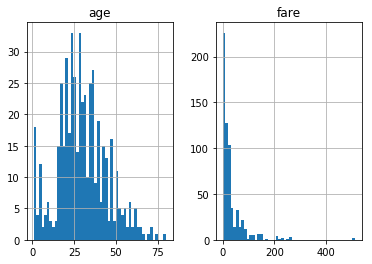

In [7]:
# let's explore the distribution of the variables to decide which arbitrary value to use

X_train.hist(bins=50)
plt.show()

In [8]:
# For this demo I will replace NA by 2 different arbitrary values
# one at the far right end of the distribution ==> 99
# and alternatively by -1, taking advantage that Age takes only positive values

# first replace with 99
X_train['Age_99'] = impute_na(X_train, 'age', 99)

# now replace with -1
X_train['Age_minus1'] = impute_na(X_train, 'age', -1)

X_train.head(15)

,age,fare,Age_99,Age_minus1
857,51.0,26.5500,51.0,51.0
52,49.0,76.7292,49.0,49.0
386,1.0,46.9000,1.0,1.0
124,54.0,77.2875,54.0,54.0
578,NaN,14.4583,99.0,-1.0
549,8.0,36.7500,8.0,8.0
118,24.0,247.5208,24.0,24.0
12,20.0,8.0500,20.0,20.0
157,30.0,8.0500,30.0,30.0
127,24.0,7.1417,24.0,24.0


Look at the rows with missing data (NaN) in Age, and see how in the new variables those were replaced by either 99 or -1.

In [9]:
# we can see a change in the variance after arbitrary value imputation  this is expected, because the percentage of missing 
#data is quite  high in Age ~20%

print('Original variable variance: ', X_train['age'].var())
print('Variance after 99 imputation: ', X_train['Age_99'].var())
print('Variance after -1 imputation: ', X_train['Age_minus1'].var())

Original variable variance:  210.45286924636747
Variance after 99 imputation:  917.6372579490387
Variance after -1 imputation:  319.3288446599532


In fact, the effect on the variance will also be driven by the magnitude of the arbitrary value selected for the imputation, compare 99 with -1.

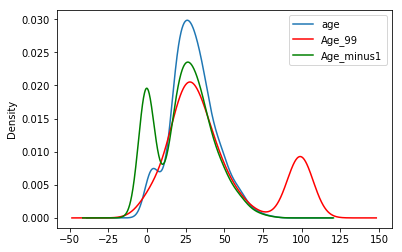

In [10]:
# we can see that the distribution has changed 
# with now more values accumulating towards the arbitrary values

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['age'].plot(kind='kde', ax=ax)

# variable imputed with 99
X_train['Age_99'].plot(kind='kde', ax=ax, color='red')

# variable imputed with -1
X_train['Age_minus1'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

Arbitrary value imputation distorts the original distribution of the variable Age. The transformed variable shows more values around arbitrary values.

Is this important?

It depends on the machine learning model you want to build. Linear models assume that the variables are normally distributed. Arbitrary value imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

On the other hand, this technique works quite well with tree based algorithms.

In [11]:
# we also said that arbitrary value imputation may affect the relationship 
# with the other variables in the dataset, let's have a look

X_train[['fare', 'age', 'Age_99', 'Age_minus1']].cov()

,fare,age,Age_99,Age_minus1
fare,2328.801583,78.468894,-48.531540,113.205643
age,78.468894,210.452869,210.452869,210.452869
Age_99,-48.531540,210.452869,917.637258,-165.272555
Age_minus1,113.205643,210.452869,-165.272555,319.328845


We see indeed that the covariance between Age and Fare is changed after the arbitrary value imputation.

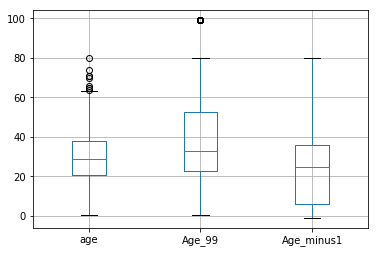

In [12]:
# Finally, I mentioned that arbitrary value imputation may affect the perception of outliers

# Let's find out using a boxplot
X_train[['age', 'Age_99', 'Age_minus1']].boxplot()

We can see that adding values at the end of the distribution mask entirely values that were outliers in the original distribution.